In [3]:
pip install caer canaro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 15.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 103.8 MB/s eta 0:00:0000:010:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import caer
import canaro
import cv2 as cv
import numpy as np
import gc

2025-06-07 06:13:07.849348: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749276788.050177      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749276788.109400      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [55]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset'

In [9]:
char_dict = {}
for char in os.listdir(char_path) :
    char_dict[char] = len(os.listdir(os.path.join(char_path, char)))
# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [10]:
#selecting the first 10 characters
characters = []
count = 0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [11]:
#create the training data
train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 4.522935628890991s
[INFO] At 1000 files
[INFO] 1454 files found in 3.632753849029541s
[INFO] At 1000 files
[INFO] 1452 files found in 3.284475803375244s
[INFO] At 1000 files
[INFO] 1354 files found in 3.8054845333099365s
[INFO] At 1000 files
[INFO] 1342 files found in 3.733652353286743s
[INFO] At 1000 files
[INFO] 1291 files found in 3.1330065727233887s
[INFO] At 1000 files
[INFO] 1206 files found in 3.3657190799713135s
[INFO] At 1000 files
[INFO] 1194 files found in 3.0914623737335205s
[INFO] At 1000 files
[INFO] 1193 files found in 4.119733095169067s
[INFO] At 1000 files
[INFO] 1079 files found in 3.0891473293304443s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 2m 53s


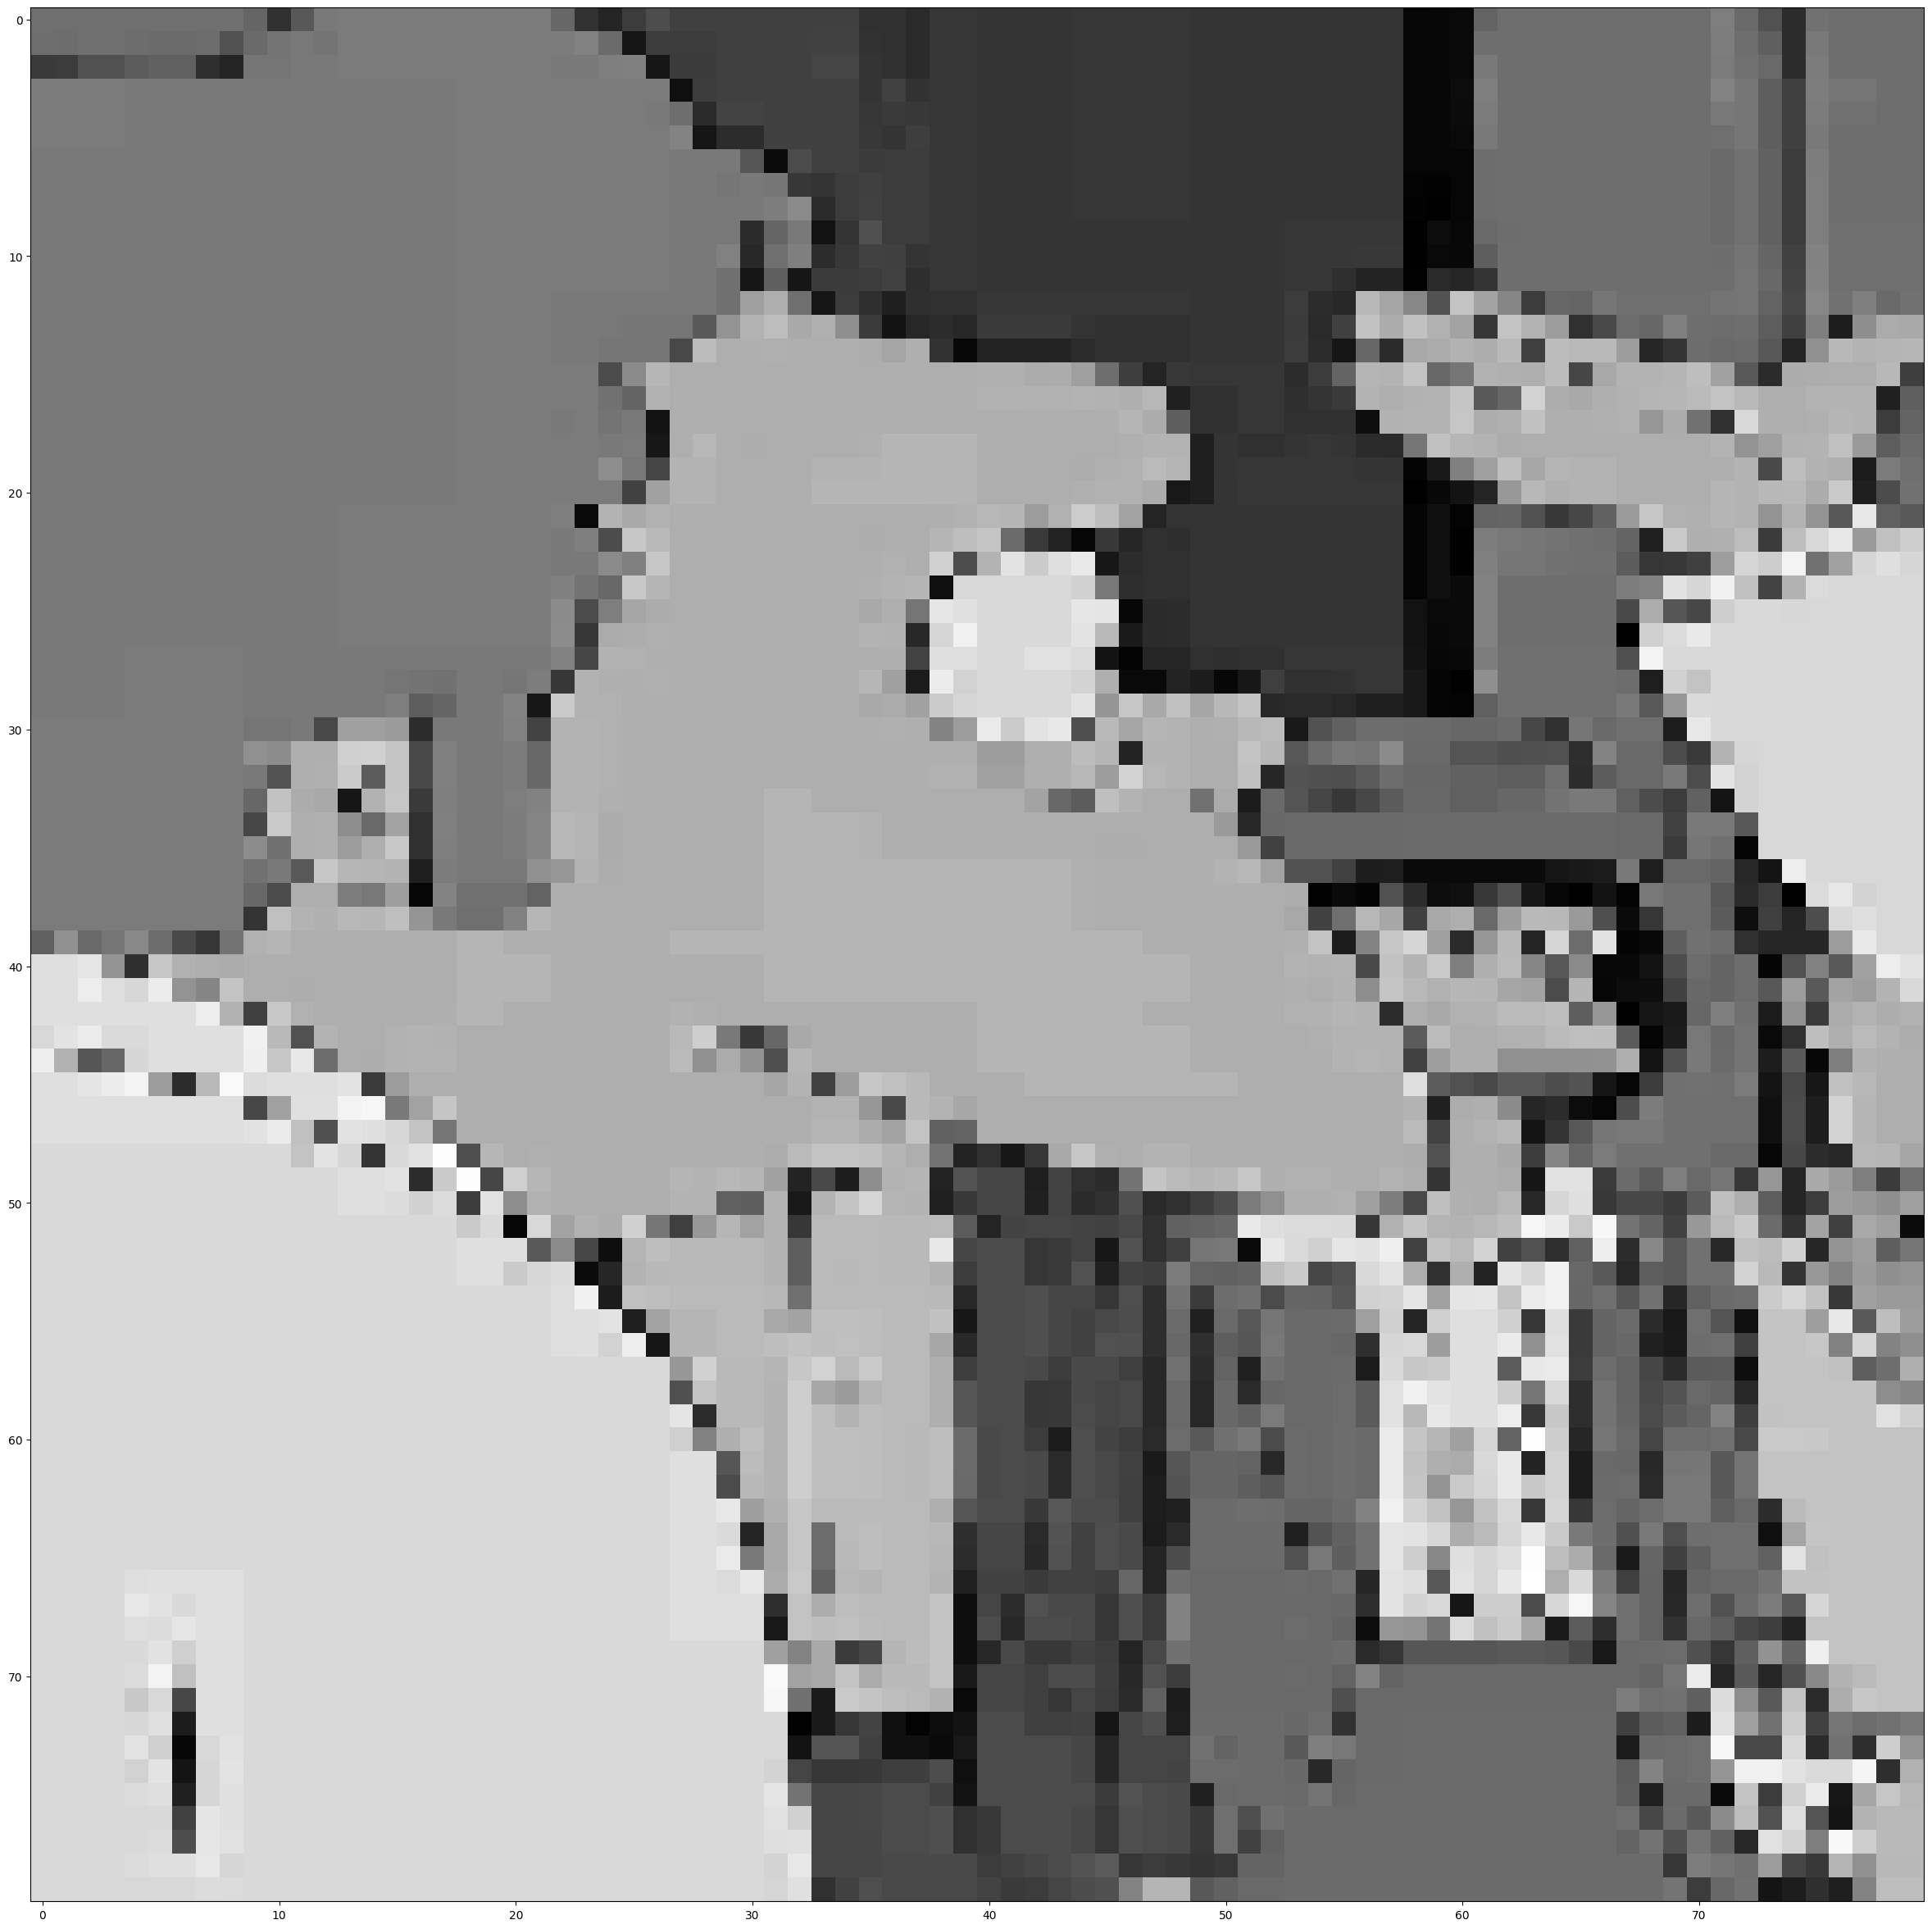

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,30))
plt.imshow(train[0][0], cmap= 'gray')
plt.show()

In [13]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=IMG_SIZE)

In [14]:
from tensorflow.keras.utils import to_categorical
# Normalize the featureSet ==> (0,1)
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(characters))

In [15]:
x_train, x_val, y_train, y_val = caer. train_val_split(featureSet, labels, val_ratio=.2)

In [16]:
del train
del featureSet
del labels
gc.collect()

0

In [18]:
BATCH_SIZE = 32
EPOCHS = 10

In [19]:
# Image data generator
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [34]:
#We can bypass the buggy canaro.models.createSimpsonsModel by creating a working version
#of the same function directly in our notebook because, the keras and tensorflow versions can't
#be downgraded.
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD

def createSimpsonsModel(IMG_SIZE, channels, output_dim, loss='categorical_crossentropy',
                        weight_decay=1e-6, learning_rate=0.001, momentum=0.9, nesterov=True):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and Dense
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(output_dim, activation='softmax'))
    
    # Optimizer
    optimizer = SGD(learning_rate=learning_rate, weight_decay=weight_decay,
                    momentum=momentum, nesterov=nesterov)
    
    # Compile model
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [41]:
# Now use this function directly
model = createSimpsonsModel(
    IMG_SIZE=IMG_SIZE,
    channels=channels,
    output_dim=len(characters),
    loss='categorical_crossentropy',
    learning_rate=0.001,
    momentum=0.9,
    nesterov=True
)

In [43]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_109 (Conv2D)                  │ (None, 80, 80, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_54 (MaxPooling2D)      │ (None, 40, 40, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 40, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_55 (MaxPooling2D)      │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_111 (Conv2D)                  │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_56 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │       6,554,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,651,914 (25.38 MB)

 Trainable params: 6,651,914 (25.38 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]

In [46]:
training = model. fit(train_gen,
                      steps_per_epoch=len(x_train)//BATCH_SIZE,
                      epochs=EPOCHS,
                      validation_data=(x_val, y_val),
                      validation_steps=len(y_val)//BATCH_SIZE,
                      callbacks = callbacks_list
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1749278585.990588     113 service.cc:148] XLA service 0x7d4cf0002f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749278585.993523     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749278585.993545     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749278586.375105     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/345 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.1183 - loss: 2.2983

I0000 00:00:1749278589.921629     113 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


345/345 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.1628 - loss: 2.2623 - val_accuracy: 0.2724 - val_loss: 2.0936 - learning_rate: 0.0100
Epoch 2/10
  1/345 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2812 - loss: 1.9656

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.2812 - loss: 1.9656 - val_accuracy: 0.2757 - val_loss: 2.0951 - learning_rate: 0.0100
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2614 - loss: 2.1048 - val_accuracy: 0.3473 - val_loss: 1.9078 - learning_rate: 0.0100
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.1562 - loss: 2.1509 - val_accuracy: 0.3535 - val_loss: 1.9037 - learning_rate: 0.0100
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3243 - loss: 1.9506 - val_accuracy: 0.4247 - val_loss: 1.6861 - learning_rate: 0.0100
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.3750 - loss: 2.0390 - val_accuracy: 0.4211 - val_loss: 1.7034 - learning_rate: 0.0100
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.3793 - loss: 1.8062 - val_accuracy: 0.4805 - val_loss: 1.5531 - learning_rate: 0.0100
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.5312 - loss: 1.5616 - 

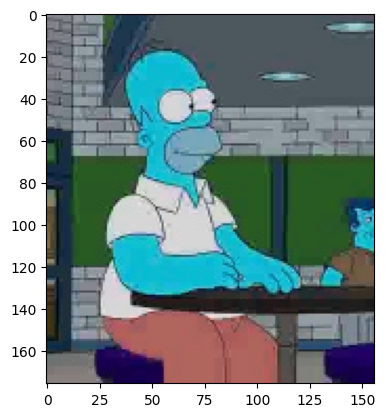

In [61]:
test_path = r'../input/the-simpsons-characters-dataset/kaggle_simpson_testset/kaggle_simpson_testset/homer_simpson_19.jpg'
img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [62]:
def prepare(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img = cv.resize(img, IMG_SIZE)
    img = caer.reshape(img, IMG_SIZE, 1)
    return img

In [63]:
predictions = model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [64]:
print(characters[np.argmax(predictions[0])])

krusty_the_clown


## 📝 Model Performance Notice

The current model has achieved an **accuracy of 46%** on the validation dataset.  
This means that the predictions may **not always be reliable** at this stage.

> 🚧 **Note**: The model requires further training and tuning to enhance its accuracy and generalization.

Thank you for your understanding and support. With more rigorous training, the model’s performance is expected to improve significantly. 🙏
